In [ ]:
!pip install -q scrapbook
!pip install -q recommenders

     |████████████████████████████████| 130 kB 27.1 MB/s 
     |████████████████████████████████| 428 kB 40.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.
     |████████████████████████████████| 335 kB 5.6 MB/s 
     |████████████████████████████████| 61 kB 1.2 MB/s 
     |████████████████████████████████| 636 kB 48.3 MB/s 
     |████████████████████████████████| 1.5 MB 41.5 MB/s 
     |████████████████████████████████| 11.8 MB 35.4 MB/s 
     |████████████████████████████████| 310 kB 57.6 MB/s 
     |████████████████████████████████| 197 kB 47.8 MB/s 
     |████████████████████████████████| 4.0 MB 41.2 MB/s 
     |████████████████████████████████| 12.4 MB 26.4 MB/s 
     |████████████████████████████████| 749 kB 48.6 MB/s 
     |███████

In [ ]:
from google.colab import drive
import json
import warnings
warnings.filterwarnings("ignore")
import sys
import os
import scrapbook as sb
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
from tempfile import TemporaryDirectory
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages
from recommenders.utils.constants import SEED
from recommenders.models.deeprec.deeprec_utils import (
    download_deeprec_resources, prepare_hparams
)
from recommenders.models.deeprec.models.xDeepFM import XDeepFMModel
from recommenders.models.deeprec.io.iterator import FFMTextIterator

print("System version: {}".format(sys.version))
print("Tensorflow version: {}".format(tf.__version__))

drive.mount('/content/drive')
root = '/content/drive/MyDrive/Desys_Group/data/'

System version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Tensorflow version: 2.8.0
Mounted at /content/drive


In [ ]:
import time
from os.path import join

"""
Override function to collect metrics
"""
class MyXDeepFMModel(XDeepFMModel):
    def fit(self, train_file, valid_file, steps, train_loss, eval_loss, eval_auc):
        print("Method override")
        """Fit the model with `train_file`. Evaluate the model on valid_file per epoch to observe the training status.
        If `test_file` is not None, evaluate it too.

        Args:
            train_file (str): training data set.
            valid_file (str): validation set.
            test_file (str): test set.

        Returns:
            object: An instance of self.
        """
        if self.hparams.write_tfevents:
            self.writer = tf.compat.v1.summary.FileWriter(
                self.hparams.SUMMARIES_DIR, self.sess.graph
            )

        train_sess = self.sess
        for epoch in range(1, self.hparams.epochs + 1):
            step = 0
            self.hparams.current_epoch = epoch

            epoch_loss = 0
            train_start = time.time()
            for (
                batch_data_input,
                impression,
                data_size,
            ) in self.iterator.load_data_from_file(train_file):
                step_result = self.train(train_sess, batch_data_input)
                (_, _, step_loss, step_data_loss, summary) = step_result
                if self.hparams.write_tfevents:
                    self.writer.add_summary(summary, step)
                epoch_loss += step_loss
                step += 1
                if step % self.hparams.show_step == 0:
                    print(
                        "step {0:d} , total_loss: {1:.4f}, data_loss: {2:.4f}".format(
                            step, step_loss, step_data_loss
                        )
                    )

            train_end = time.time()
            train_time = train_end - train_start

            if self.hparams.save_model:
                if not os.path.exists(self.hparams.MODEL_DIR):
                    os.makedirs(self.hparams.MODEL_DIR)
                if epoch % self.hparams.save_epoch == 0:
                    save_path_str = join(self.hparams.MODEL_DIR, "epoch_" + str(epoch))
                    self.saver.save(sess=train_sess, save_path=save_path_str)

            eval_start = time.time()
            eval_res = self.run_eval(valid_file)
            train_info = ",".join(
                [
                    str(item[0]) + ":" + str(item[1])
                    for item in [("logloss loss", epoch_loss / step)]
                ]
            )
            eval_info = ", ".join(
                [
                    str(item[0]) + ":" + str(item[1])
                    for item in sorted(eval_res.items(), key=lambda x: x[0])
                ]
            )

            eval_end = time.time()
            eval_time = eval_end - eval_start

            print(
                "at epoch {0:d}".format(epoch)
                + "\ntrain info: "
                + train_info
                + "\neval info: "
                + eval_info
            )
            print(
                "at epoch {0:d} , train time: {1:.1f} eval time: {2:.1f}".format(
                    epoch, train_time, eval_time
                )
            )

            steps.append(epoch)
            train_loss.append(epoch_loss/step)
            eval_loss.append(eval_res['logloss'])
            eval_auc.append(eval_res['auc'])


        if self.hparams.write_tfevents:
            self.writer.close()

        return self

In [ ]:
with open(os.path.join(root, r'meta_asset.json')) as meta_f:
    meta = json.load(meta_f)
EPOCHS_FOR_SYNTHETIC_RUN = 15
EPOCHS_FOR_CRITEO_RUN = 10
EPOCHS_FOR_OPENSEA_RUN = 15
BATCH_SIZE_SYNTHETIC = 128
BATCH_SIZE_CRITEO = 4096
BATCH_SIZE_OPENSEA = 256
RANDOM_SEED = SEED  # set to None for non-deterministic result
FIELD_COUNT = meta['field_count']
FEATURE_COUNT = meta['feature_count'] 
FIELD_COUNT, FEATURE_COUNT

(14, 85806)

In [ ]:
yaml_file = os.path.join(root, r'xDeepFM.yaml')
train_file = os.path.join(root, r'train_asset.ffm')
valid_file = os.path.join(root, r'valid_asset.ffm')
test_file = os.path.join(root, r'test_asset.ffm')
output_file = os.path.join(root, r'output_asset.txt')

In [ ]:
hparams = prepare_hparams(yaml_file, 
                          FEATURE_COUNT=FEATURE_COUNT, 
                          FIELD_COUNT=FIELD_COUNT, 
                          cross_l2=0.001, 
                          embed_l2=0.001, 
                          layer_l2=0.001,
                          learning_rate=0.0001, 
                          batch_size=BATCH_SIZE_OPENSEA, 
                          epochs=EPOCHS_FOR_OPENSEA_RUN, 
                          cross_layer_sizes=[20, 10], 
                          init_value=0.1, 
                          layer_sizes=[20,20],
                          use_Linear_part=True, 
                          use_CIN_part=True, 
                          use_DNN_part=True,
                          user_dropout=True,
                          dropout=[0.2, 0.2],
                          # save_model=True,
                          # MODEL_DIR=root
                          )

input_creator = FFMTextIterator

## sometimes we don't want to train a model from scratch
## then we can load a pre-trained model like this: 
## model.load_model(r'your_model_path')
model = MyXDeepFMModel(hparams, input_creator, seed=RANDOM_SEED)
print(model.run_eval(test_file))
steps, train_loss, eval_loss, eval_auc = [], [], [], []
model.fit(train_file, valid_file, steps, train_loss, eval_loss, eval_auc)
res_syn = model.run_eval(test_file)
print(res_syn)
sb.glue("res_syn", res_syn)
model.predict(test_file, output_file)

Add linear part.
Add CIN part.
Add DNN part.
{'auc': 0.4545, 'logloss': 0.7813}
Method override
at epoch 1
train info: logloss loss:3.4921845788011154
eval info: auc:0.6406, logloss:0.5736
at epoch 1 , train time: 21.2 eval time: 1.7
at epoch 2
train info: logloss loss:1.9937237931516605
eval info: auc:0.9428, logloss:0.2497
at epoch 2 , train time: 20.1 eval time: 1.6
at epoch 3
train info: logloss loss:1.1007333205530818
eval info: auc:0.9826, logloss:0.1391
at epoch 3 , train time: 20.4 eval time: 1.5
at epoch 4
train info: logloss loss:0.6123995688586189
eval info: auc:0.9913, logloss:0.0825
at epoch 4 , train time: 20.3 eval time: 1.7
at epoch 5
train info: logloss loss:0.35099299256793987
eval info: auc:0.9923, logloss:0.0681
at epoch 5 , train time: 20.5 eval time: 1.6
at epoch 6
train info: logloss loss:0.21598309764085105
eval info: auc:0.9928, logloss:0.0637
at epoch 6 , train time: 20.6 eval time: 1.6
at epoch 7
train info: logloss loss:0.14604750742165806
eval info: auc:0.9

In [ ]:
print(steps, train_loss, eval_loss, eval_auc)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] [3.4921845788011154, 1.9937237931516605, 1.1007333205530818, 0.6123995688586189, 0.35099299256793987, 0.21598309764085105, 0.14604750742165806, 0.11118872796955961, 0.09421089290382383, 0.08610756932118069, 0.08164080464468597, 0.0787543002337503, 0.07636987339383877, 0.07344807357119676, 0.07042675673628386] [0.5736, 0.2497, 0.1391, 0.0825, 0.0681, 0.0637, 0.0618, 0.0608, 0.0601, 0.0597, 0.0594, 0.0592, 0.0589, 0.0588, 0.0586] [0.6406, 0.9428, 0.9826, 0.9913, 0.9923, 0.9928, 0.9931, 0.9932, 0.9933, 0.9934, 0.9934, 0.9935, 0.9935, 0.9935, 0.9936]


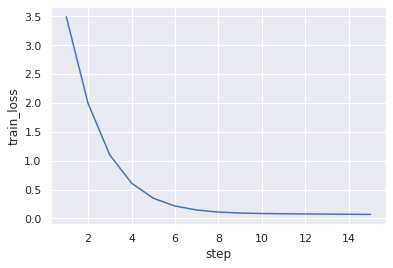

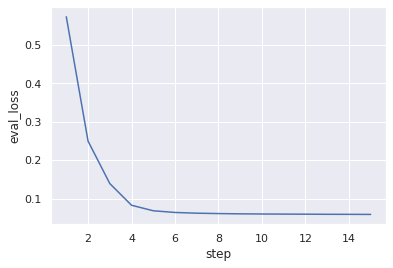

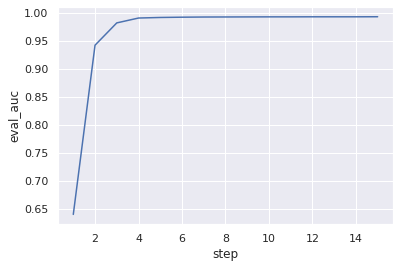

In [ ]:
def line_plot(data, x, y):
  sns.lineplot(x=data[x], y=data[y])
  plt.xlabel(x)
  plt.ylabel(y)
  plt.show()

records = {"step": steps, "train_loss": train_loss, "eval_loss": eval_loss, "eval_auc": eval_auc}

line_plot(records, "step", "train_loss")
line_plot(records, "step", "eval_loss")
line_plot(records, "step", "eval_auc")

In [ ]:
test_file

'/content/drive/MyDrive/Desys_Group/data/test_asset.ffm'